<a href="https://colab.research.google.com/github/HariCodesThings/Data-Science-Final-Project/blob/master/Data_Modeling_and_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import  KNeighborsRegressor
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn.preprocessing import StandardScaler

## Installs and Loading Previous Data

In [409]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)


Mounted at /content/drive/


In [0]:
!cp "/content/drive/My Drive/DATA301 Project/coronavirus_raw.csv" "coronavirus_raw.csv"
!cp "/content/drive/My Drive/DATA301 Project/chinese_cities_cleaned.csv" "chinese_cities_cleaned.csv"
!cp "/content/drive/My Drive/DATA301 Project/covid_by_country_filtered.csv" "covid_by_country_filtered.csv"

### Duplicate code to reproduce cleaning for coronavirus country/province (time-series) data

In [411]:
from datetime import datetime

df_coronavirus = pd.read_csv("coronavirus_raw.csv")
cleaned = []
for entry in range(len(df_coronavirus)):
  cleaned.append(datetime.fromtimestamp(df_coronavirus['updateTime'][entry]/1000)
                  .strftime("%x"))
  
df_coronavirus['updateTime_cleaned'] = np.array(cleaned)
df_coronavirus.head(2)

,provinceName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount,comment,operator,locationId,countryShortCode,countryFullName,continentName,countryName,provinceShortName,continentEnglishName,countryEnglishName,provinceEnglishName,updateTime,statisticsData,cities,createTime,modifyTime,cityName,updateTime_cleaned
0,关岛,3.0,3,0.0,0,0,NaN,chend,0,GU,Guam,北美洲,关岛,关岛,North America,Guam,Guam,1584487275191,NaN,NaN,NaN,NaN,NaN,03/17/20
1,美属维尔京群岛,2.0,2,0.0,0,0,NaN,chend,0,USVI,United States Virgin Islands,北美洲,美属维尔京群岛,美属维尔京群岛,North America,NaN,NaN,1584487275191,NaN,NaN,NaN,NaN,NaN,03/17/20


In [412]:
df_coronavirus['cities'].fillna('[]', inplace = True)
df_coronavirus[df_coronavirus['cities']=='[]'].head(2)

,provinceName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount,comment,operator,locationId,countryShortCode,countryFullName,continentName,countryName,provinceShortName,continentEnglishName,countryEnglishName,provinceEnglishName,updateTime,statisticsData,cities,createTime,modifyTime,cityName,updateTime_cleaned
0,关岛,3.0,3,0.0,0,0,NaN,chend,0,GU,Guam,北美洲,关岛,关岛,North America,Guam,Guam,1584487275191,NaN,[],NaN,NaN,NaN,03/17/20
1,美属维尔京群岛,2.0,2,0.0,0,0,NaN,chend,0,USVI,United States Virgin Islands,北美洲,美属维尔京群岛,美属维尔京群岛,North America,NaN,NaN,1584487275191,NaN,[],NaN,NaN,NaN,03/17/20


In [413]:
df_coronavirus_filtered = df_coronavirus[df_coronavirus['countryEnglishName']
                                         .isna() != True]
df_coronavirus_filtered.head(2)

,provinceName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount,comment,operator,locationId,countryShortCode,countryFullName,continentName,countryName,provinceShortName,continentEnglishName,countryEnglishName,provinceEnglishName,updateTime,statisticsData,cities,createTime,modifyTime,cityName,updateTime_cleaned
0,关岛,3.0,3,0.0,0,0,NaN,chend,0,GU,Guam,北美洲,关岛,关岛,North America,Guam,Guam,1584487275191,NaN,[],NaN,NaN,NaN,03/17/20
2,以色列,332.0,337,0.0,5,0,NaN,chend,955009,ISR,Israel,亚洲,以色列,以色列,Asia,Israel,Israel,1584484401599,https://file1.dxycdn.com/2020/0315/982/3402160...,[],NaN,NaN,NaN,03/17/20


# **Machine Learning and Model Selection**

## Regression Models (supervised prediction)

In [414]:
df_by_countries_filtered = pd.read_csv("covid_by_country_filtered.csv")
df_by_countries_filtered.head()

,countryEnglishName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount
0,Afghanistan,22,22,0,0,0
1,Albania,54,55,0,0,1
2,Algeria,45,60,0,10,5
3,Andorra,14,15,0,1,0
4,Antigua and Barbuda,1,1,0,0,0


Attempt to use linear regression to predict death counts, based on confirmed and/or cured count. Went somewhat poorly since there are not enough variables to predict on but linear regression seems to do a decent job of generalizing...

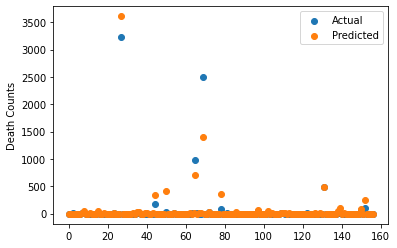

In [415]:
model = LinearRegression()
model.fit(df_by_countries_filtered[["confirmedCount"]], df_by_countries_filtered["deadCount"])

y_new = model.predict(df_by_countries_filtered[["confirmedCount"]])

plt.scatter(range(0, len(df_by_countries_filtered)), df_by_countries_filtered['deadCount'])
plt.scatter(range(0, len(df_by_countries_filtered)), y_new)
plt.ylabel('Death Counts')
plt.legend(['Actual', 'Predicted'])
plt.savefig('LinReg')

In [0]:
def get_cv_error_(features, model):
  pipeline = make_pipeline(
      StandardScaler(),
      model
  )

  # calculate errors from cross-validation
  cv_errs = -cross_val_score(pipeline, X=df_by_countries_filtered[features], 
                             y=df_by_countries_filtered["deadCount"],
                             scoring="neg_mean_squared_error", cv=10)
  
  # calculate average of the cross-validation errors
  return cv_errs.mean()

In [417]:
from sklearn import linear_model

errs = pd.Series()
for features in [(["confirmedCount", "curedCount"]),
                 (["confirmedCount"]),
                 (["curedCount"])]:
                errs[str(features)] = get_cv_error_(features, LinearRegression())
errs**0.5

['confirmedCount', 'curedCount']     274.119160
['confirmedCount']                   190.641866
['curedCount']                      1519.002010
dtype: float64

SGD does worse... not my much, but it isn't doing better than linear

In [418]:
errs = pd.Series()
for features in [(["confirmedCount", "curedCount"]),
                 (["confirmedCount"]),
                 (["curedCount"])]:
                errs[str(features)] = get_cv_error_(features, linear_model.SGDRegressor(max_iter=1000))
errs**0.5

['confirmedCount', 'curedCount']     307.099167
['confirmedCount']                   194.433402
['curedCount']                      1504.605582
dtype: float64

Attempt to use K-nearest regressor for the same feature set (here, confirmedCount was the only feature that made sense to include)... seemed to  produce very wonky results, moreso than simple linear regression. 

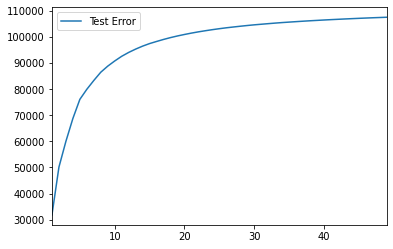

In [419]:
df_errors = pd.DataFrame(columns = ['k', 'test_MSE'])

for k in range(1, 50):
  pipeline_errors = make_pipeline(
        StandardScaler(),
        KNeighborsRegressor(k))
  
  pipeline_errors.fit(X=df_by_countries_filtered[["confirmedCount"]],
                      y=df_by_countries_filtered["deadCount"])
  
  cv_mse_test = -cross_val_score(pipeline_errors, X= df_by_countries_filtered[["confirmedCount"]], 
                                y=df_by_countries_filtered["deadCount"],
                                scoring="neg_mean_squared_error", cv=10)
  
  df_errors.loc[k] = [k, cv_mse_test.mean()]

df_errors.plot(y = 'test_MSE', label = "Test Error")

When using Random Forest, the results look closer to what we would expect, with lower values of estimators yielding better MSE/RMSE score...

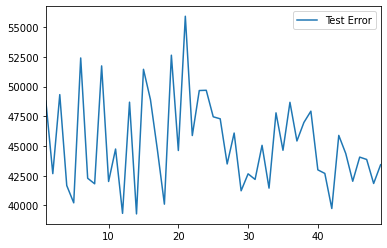

In [420]:
from sklearn.ensemble import RandomForestRegressor

df_errors = pd.DataFrame(columns = ['k', 'test_MSE'])

for k in range(1, 50):
  pipeline_errors = make_pipeline(
        StandardScaler(),
        RandomForestRegressor(n_estimators = k))
  
  pipeline_errors.fit(X=df_by_countries_filtered[["confirmedCount"]],
                      y=df_by_countries_filtered["deadCount"])
  
  cv_mse_test = -cross_val_score(pipeline_errors, X= df_by_countries_filtered[["confirmedCount"]], 
                                y=df_by_countries_filtered["deadCount"],
                                scoring="neg_mean_squared_error", cv=10)
  
  df_errors.loc[k] = [k, cv_mse_test.mean()]

df_errors.plot(y = 'test_MSE', label = "Test Error")

In [421]:
clf = GridSearchCV(pipeline_errors,
                   param_grid={
                       "randomforestregressor__n_estimators": range(1, 50)
                       },
                   scoring="neg_mean_squared_error",
                   cv=10)
clf.fit(df_by_countries_filtered[["confirmedCount"]],df_by_countries_filtered["deadCount"])
clf.best_estimator_

Pipeline(memory=None,
         steps=[('standardscaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=7, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

At its best... Random Forest compares favorably to the other regression models I looked at (specifically linear and k-nearest). Although, Linear Regressor did do a good job of generalizing, as I mentioned before.

## Time Series (Forecasting)

In [422]:
df_coronavirus_filtered.index = pd.to_datetime(df_coronavirus_filtered['updateTime_cleaned'])
df_coronavirus_filtered

,provinceName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount,comment,operator,locationId,countryShortCode,countryFullName,continentName,countryName,provinceShortName,continentEnglishName,countryEnglishName,provinceEnglishName,updateTime,statisticsData,cities,createTime,modifyTime,cityName,updateTime_cleaned
updateTime_cleaned,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,关岛,3.0,3,0.0,0,0,NaN,chend,0,GU,Guam,北美洲,关岛,关岛,North America,Guam,Guam,1584487275191,NaN,[],NaN,NaN,NaN,03/17/20
2020-03-17,以色列,332.0,337,0.0,5,0,NaN,chend,955009,ISR,Israel,亚洲,以色列,以色列,Asia,Israel,Israel,1584484401599,https://file1.dxycdn.com/2020/0315/982/3402160...,[],NaN,NaN,NaN,03/17/20
2020-03-17,斯洛伐克,97.0,97,0.0,0,0,NaN,chend,963007,SVK,Slovakia,欧洲,斯洛伐克,斯洛伐克,Europe,Slovakia,Slovakia,1584483818068,https://file1.dxycdn.com/2020/0315/353/3402160...,[],NaN,NaN,NaN,03/17/20
2020-03-17,冈比亚,1.0,1,0.0,0,0,NaN,chend,982005,GMB,Gambia,非洲,冈比亚,冈比亚,Africa,Gambia,Gambia,1584483753903,NaN,[],NaN,NaN,NaN,03/17/20
2020-03-17,阿曼,21.0,33,0.0,12,0,NaN,chend,955013,OMN,Oman,亚洲,阿曼,阿曼,Asia,Oman,Oman,1584483497693,https://file1.dxycdn.com/2020/0315/945/3402160...,[],NaN,NaN,NaN,03/17/20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-21,辽宁省,NaN,0,1.0,0,0,NaN,zyyun,210000,NaN,NaN,亚洲,中国,辽宁,Asia,China,Liaoning,1579634890131,NaN,[],1.579626e+12,1.579626e+12,NaN,01/21/20
2020-01-21,台湾,NaN,1,0.0,0,0,NaN,huanshi,710000,NaN,NaN,亚洲,中国,台湾,Asia,China,Taiwan,1579634890131,NaN,[],1.579617e+12,1.579617e+12,NaN,01/21/20
2020-01-21,香港,NaN,0,117.0,0,0,NaN,huanshi,810000,NaN,NaN,亚洲,中国,香港,Asia,Hongkong,Hongkong,1579634890131,NaN,[],1.579617e+12,1.579617e+12,NaN,01/21/20


In [423]:
df_time_series_hub = df_coronavirus_filtered[
    df_coronavirus_filtered["provinceEnglishName"] == "Hubei"]
df_time_series_hub.head(3)

,provinceName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount,comment,operator,locationId,countryShortCode,countryFullName,continentName,countryName,provinceShortName,continentEnglishName,countryEnglishName,provinceEnglishName,updateTime,statisticsData,cities,createTime,modifyTime,cityName,updateTime_cleaned
updateTime_cleaned,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,湖北省,8685.0,67799,0.0,56003,3111,NaN,NaN,420000,NaN,NaN,亚洲,中国,湖北,Asia,China,Hubei,1584445621306,https://file1.dxycdn.com/2020/0223/618/3398299...,"[{'cityName': '武汉', 'currentConfirmedCount': 8...",NaN,NaN,NaN,03/17/20
2020-03-17,湖北省,8691.0,67799,0.0,55997,3111,NaN,NaN,420000,NaN,NaN,亚洲,中国,湖北,Asia,China,Hubei,1584440660265,https://file1.dxycdn.com/2020/0223/618/3398299...,"[{'cityName': '武汉', 'currentConfirmedCount': 8...",NaN,NaN,NaN,03/17/20
2020-03-17,湖北省,8701.0,67799,0.0,55987,3111,NaN,NaN,420000,NaN,NaN,亚洲,中国,湖北,Asia,China,Hubei,1584403998257,https://file1.dxycdn.com/2020/0223/618/3398299...,"[{'cityName': '武汉', 'currentConfirmedCount': 9...",NaN,NaN,NaN,03/17/20


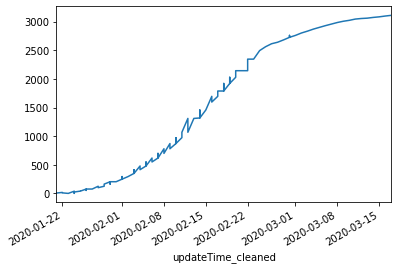

In [424]:
df_time_series_hub["deadCount"].plot.line()

In [425]:
df_time_series_us = df_coronavirus_filtered[
    df_coronavirus_filtered["countryEnglishName"] == "United States of America"]
df_time_series_us.head(3)


,provinceName,currentConfirmedCount,confirmedCount,suspectedCount,curedCount,deadCount,comment,operator,locationId,countryShortCode,countryFullName,continentName,countryName,provinceShortName,continentEnglishName,countryEnglishName,provinceEnglishName,updateTime,statisticsData,cities,createTime,modifyTime,cityName,updateTime_cleaned
updateTime_cleaned,,,,,,,,,,,,,,,,,,,,,,,,
2020-03-17,美国,5538.0,5709,0.0,74,97,NaN,chend,971002,USA,United States of America,北美洲,美国,美国,North America,United States of America,United States of America,1584476307899,https://file1.dxycdn.com/2020/0315/553/3402160...,[],NaN,NaN,NaN,03/17/20
2020-03-17,美国,5538.0,5709,0.0,74,97,NaN,yuyb,971002,USA,United States of America,北美洲,美国,美国,North America,United States of America,United States of America,1584470183217,https://file1.dxycdn.com/2020/0315/553/3402160...,[],NaN,NaN,NaN,03/17/20
2020-03-17,美国,4994.0,5139,0.0,48,97,NaN,yuyb,971002,USA,United States of America,北美洲,美国,美国,North America,United States of America,United States of America,1584468710736,https://file1.dxycdn.com/2020/0315/553/3402160...,[],NaN,NaN,NaN,03/17/20


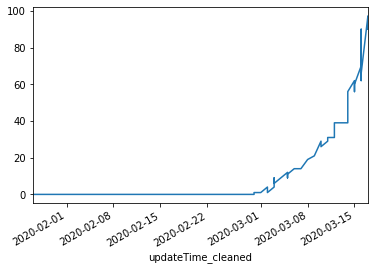

In [426]:
df_time_series_us["deadCount"].plot.line()

In [427]:
# Convert dates to a decimal year
date = df_time_series_hub.index
t = date.year + (30 * (date.month - 1) + date.day) / 365
t

Float64Index([2020.2109589041097, 2020.2109589041097, 2020.2109589041097,
              2020.2082191780821, 2020.2082191780821, 2020.2082191780821,
              2020.2054794520548, 2020.2054794520548, 2020.2027397260274,
              2020.2027397260274,
              ...
              2020.0657534246575, 2020.0657534246575, 2020.0657534246575,
              2020.0630136986301, 2020.0602739726028, 2020.0602739726028,
              2020.0602739726028, 2020.0602739726028, 2020.0602739726028,
              2020.0575342465754],
             dtype='float64', name='updateTime_cleaned', length=380)

Started with linear regression and then shifted to Light GBM to closely fit curve for Hubei

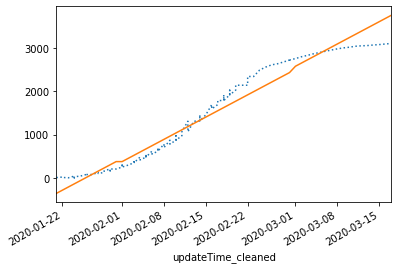

In [428]:
from sklearn.preprocessing import PolynomialFeatures
import lightgbm as lgb 

y_train = df_time_series_hub['deadCount']

# Fit linear regression of y on t and t^2
pipeline = make_pipeline(
    #PolynomialFeatures(degree=2, include_bias=False),
    LinearRegression()
)
pipeline.fit(X=t.to_frame(), y=y_train)

# Store model predictions in a Series for easy plotting
y_train_ = pd.Series(
    pipeline.predict(X=t.to_frame()),
    index=y_train.index
)

# Plot the data and the fitted trend
y_train.plot.line(style=":")
y_train_.plot.line()

In [429]:
y_train = df_time_series_hub['deadCount']
X = t.to_frame()
y_new = y_train.copy().sort_index()
#y_shifted .shift(1, axis = 0)

y_new

updateTime_cleaned
2020-01-21       6
2020-01-22      17
2020-01-22      17
2020-01-22       9
2020-01-22       9
              ... 
2020-03-16    3099
2020-03-16    3099
2020-03-17    3111
2020-03-17    3111
2020-03-17    3111
Name: deadCount, Length: 380, dtype: int64

In Hubei, the upwards curve started on the 22nd of Jan... in the US, it started on the first of March. Use the loose trend that we got from Hubei to predict what would happen to death rates in the future for the US...

In [0]:
#X_agg['updateTime_cleaned'].min()
X_new = X.copy().sort_index()
X_new = pd.DataFrame(X_new)
X_new['y'] = y_new.values
X_new = X_new.drop(['updateTime_cleaned'], axis=1)
X_new = X_new.reset_index()
X_agg = X_new.groupby(['updateTime_cleaned']).max()
y_t =  X_agg['y']
X_agg['y0'] =y_t.shift(1, axis = 0)
X_agg = X_agg[np.isnan(X_agg['y0']) == False]
X_a =  X_agg.reset_index()
X_a['updateTime_cleaned'] = X_a['updateTime_cleaned']  - X_a['updateTime_cleaned'].min()
X_a = X_a.set_index(['updateTime_cleaned'])



Train time series model on China with previous day's number of death as a paramater to the Linear Regressor (does MUCH better now)

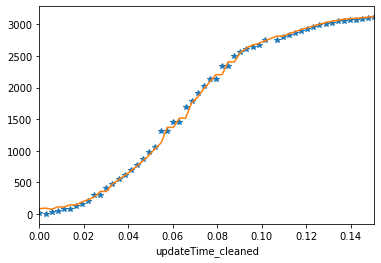

In [437]:
y_n = X_a['y']


pipeline = make_pipeline(
    LinearRegression()
)
X_n = X_a.drop(['y'], axis = 1)
pipeline.fit(X=X_n.reset_index(), y=y_n)

# Store model predictions in a Series for easy plotting
y_n_ = pd.Series(
    pipeline.predict(X=X_n.reset_index()),
    index=X_n.index
)

# Plot the data and the fitted trend
y_n.plot.line(style="*")
y_n_.plot.line()


Refitted the model that was trained on the Chinese death count data with US data, and previous day (first-differences procedure followed) death count as a parameter still...

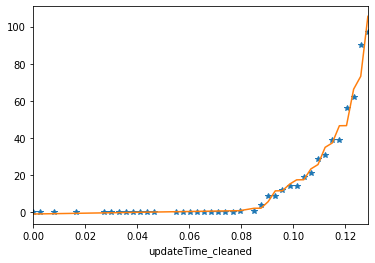

In [442]:
y_train_us = df_time_series_us['deadCount']
#y_shifted .shift(1, axis = 0)
date = df_time_series_us.index
t_us = date.year + (30 * (date.month - 1) + date.day) / 365
X_us = t_us.to_frame()
y_new_us = y_train_us.copy().sort_index()
X_new_us = X_us.copy().sort_index()
X_new_us = pd.DataFrame(X_new_us)
X_new_us['y'] = y_new_us.values
X_new_us = X_new_us.drop(['updateTime_cleaned'], axis=1)
X_new_us = X_new_us.reset_index()
X_agg_us = X_new_us.groupby(['updateTime_cleaned']).max()
y_new_us =X_agg_us['y']
X_agg_us['y0'] =y_new_us.shift(1, axis = 0)
X_agg_us = X_agg_us[np.isnan(X_agg_us['y0']) == False]
#X_agg_us = X_agg_us[X_agg_us['y0']> 0 ]
X_a_us =  X_agg_us.reset_index()
X_a_us['updateTime_cleaned'] = X_a_us['updateTime_cleaned']  - X_a_us['updateTime_cleaned'].min()
X_a_us = X_a_us.set_index(['updateTime_cleaned'])
y_t_us =  X_a_us['y'].sort_index()
X_a_us = X_a_us.drop(['y'], axis = 1)
pipeline.fit(X=X_a_us.reset_index(), y=y_t_us)

# train US with data from China prefitted
y_train_us_ = pd.Series(
    pipeline.predict(X=X_a_us.reset_index()),
    index=X_a_us.index
)

# Plot the data and the fitted trend
y_t_us.plot.line(style="*")
y_train_us_.plot.line()





In [447]:
#y_train_us
off = 2020 + (30*0 + 27)/365
#date.year + (30 * (date.month - 1) + date.day) / 365
index = pd.date_range(start='3/18/2020', end='3/30/2020')
X_pf = pd.DataFrame(index)
X_pf['updateTime_cleaned'] =pd.to_datetime(X_pf[0] )
X_pf['updateTime_cleaned_orig'] = X_pf['updateTime_cleaned'].dt.year + \
                                  ((30 * X_pf['updateTime_cleaned'].dt.month - 1) \
                                   + X_pf['updateTime_cleaned'].dt.day) / 365 
X_pf['updateTime_cleaned'] = X_pf['updateTime_cleaned_orig'] - off
X_pf

,0,updateTime_cleaned,updateTime_cleaned_orig
0,2020-03-18,0.219178,2020.293151
1,2020-03-19,0.221918,2020.295890
2,2020-03-20,0.224658,2020.298630
3,2020-03-21,0.227397,2020.301370
4,2020-03-22,0.230137,2020.304110
5,2020-03-23,0.232877,2020.306849
6,2020-03-24,0.235616,2020.309589
7,2020-03-25,0.238356,2020.312329
8,2020-03-26,0.241096,2020.315068
9,2020-03-27,0.243836,2020.317808


Let's see 5 days from now, what the death count is US is predicted to be from this time series model...

In [449]:
pipeline.predict(X=[[0.235616	, 97]])

array([115.99615885])

Even further along, 10 days from now--given that death toll then was 115..., the model predicts that death rises again to 137. It suggests that the death rate still climbs fast, but training on China data tamed the growth a little bit.

In [455]:
pipeline.predict(X=[[0.249315,115]])


array([137.00340543])